In [1]:
import pandas as pd
import numpy as np
from math import ceil

# plotting
import matplotlib.pyplot as plt
#import seaborn as sns

# handling trajectory and other geo-data
import geopandas as gpd
import movingpandas as mpd
from shapely.geometry import Point, LineString, Polygon
from shapely import wkt
from shapely.wkt import loads

#2 min

# points = pd.read_pickle("Data/points.pkl")
# # display(points_df.head())
# trajs_df = pd.read_pickle("Data/trajectories.pkl")
# # display(trajs_df.head())

points_file = '../Data/gbg_trajectories_points_2019.csv'
trajs_file = '../Data/gbg_trajectories_2019_crossing.csv'
points_pickle_file = '../Data/points.pkl'
trajs_pickle_file = '../Data/trajectories.pkl'

points = pd.read_pickle(points_pickle_file)
display(points.head())
trajs_df = pd.read_pickle(trajs_pickle_file)
display(trajs_df.head())

,,x,y,timestamp,trajectory_sid
,trajectory_sid,,,,
931193,1,322906.188012,6.416545e+06,2019-09-04 15:58:49+02:00,1
931194,1,322874.393157,6.416413e+06,2019-09-04 15:58:54+02:00,1
931195,1,322844.134677,6.416278e+06,2019-09-04 15:58:59+02:00,1
931196,1,322816.213664,6.416140e+06,2019-09-04 15:59:04+02:00,1
931197,1,322794.293079,6.415999e+06,2019-09-04 15:59:09+02:00,1


,start_time,stop_time,duration,data_points,distance,speed,line
sid,,,,,,,
1,2019-09-04 15:18:24+02:00,2019-09-04 16:03:24+02:00,2700,541,64885,86.513333,LINESTRING (342610.0375303831 6464707.88746338...
3,2019-10-19 18:55:00+02:00,2019-10-19 20:54:12+02:00,7152,1429,206390,103.887584,LINESTRING (324460.85687151505 6386857.1792007...
4,2019-10-28 04:13:07+01:00,2019-10-28 05:14:17+01:00,3670,648,96755,94.909537,LINESTRING (321475.2318731322 6398016.73146137...
7,2019-11-23 09:10:37+01:00,2019-11-23 10:06:47+01:00,3370,670,77225,82.495549,LINESTRING (329279.0401737231 6403344.89584320...
11,2019-09-16 18:05:00+02:00,2019-09-16 18:53:53+02:00,2933,507,75961,93.235459,LINESTRING (320825.56008272676 6399036.5784418...


In [2]:
points_df = points.copy()

In [3]:
# points = points[len(points)-500000:]
points['segment_distance'] = np.nan
points['segment_duration'] = np.nan
points.tail()

# 10 min

def compute_distance(row):
    if row.name == 0 or row['trajectory_sid'] != row['prev_trajectory_sid']:
        return 0
    t1 = (row['prev_x'], row['prev_y'])
    t2 = (row['x'], row['y'])
    return Point(t1).distance(Point(t2))

# Before using, you need to create previous value columns
points['prev_x'] = points['x'].shift(1)
points['prev_y'] = points['y'].shift(1)
points['prev_trajectory_sid'] = points['trajectory_sid'].shift(1)

points['segment_distance'] = points.apply(compute_distance, axis=1)

# Cleanup
points.drop(columns=['prev_x', 'prev_y', 'prev_trajectory_sid'], inplace=True)


# 2min

def compute_time_diff(row):
    if row.name == 0 or row['trajectory_sid'] != row['prev_trajectory_sid']:
        return np.nan
    time_diff = row['timestamp'] - row['prev_timestamp']
    return time_diff.total_seconds()

# Before using, you need to create previous value columns
points['prev_timestamp'] = points['timestamp'].shift(1)
points['prev_trajectory_sid'] = points['trajectory_sid'].shift(1)

points['segment_duration'] = points.apply(compute_time_diff, axis=1)

# Cleanup
points.drop(columns=['prev_timestamp', 'prev_trajectory_sid'], inplace=True)



In [4]:
points['segment_velocity (m/s)'] = 0

points['segment_velocity (m/s)'] = np.where(
    points['segment_duration'] != 0,
    points['segment_distance'] / points['segment_duration'],
    0
)

points['segment_velocity (km/h)'] = points['segment_velocity (m/s)'] * 3.6



In [5]:
points = points.rename(columns={"trajectory_sid": "old_traj_sid"})
points.head()

,,x,y,timestamp,old_traj_sid,segment_distance,segment_duration,segment_velocity (m/s),segment_velocity (km/h)
,trajectory_sid,,,,,,,,
931193,1,322906.188012,6.416545e+06,2019-09-04 15:58:49+02:00,1,0.000000,NaN,NaN,NaN
931194,1,322874.393157,6.416413e+06,2019-09-04 15:58:54+02:00,1,135.705800,5.0,27.141160,97.708176
931195,1,322844.134677,6.416278e+06,2019-09-04 15:58:59+02:00,1,138.138039,5.0,27.627608,99.459388
931196,1,322816.213664,6.416140e+06,2019-09-04 15:59:04+02:00,1,141.131807,5.0,28.226361,101.614901
931197,1,322794.293079,6.415999e+06,2019-09-04 15:59:09+02:00,1,142.752909,5.0,28.550582,102.782095


In [6]:
vel_means = pd.DataFrame()
grouped_20_rows = points.groupby('old_traj_sid')
vel_means['mean_velocity'] = grouped_20_rows['segment_velocity (km/h)'].mean()
vel_means['Number of data points'] = grouped_20_rows['old_traj_sid'].count()
vel_means['duration'] = grouped_20_rows['segment_duration'].sum()
vel_means = vel_means.drop(vel_means[vel_means['duration'] == 0].index)
vel_means['total_distance'] = grouped_20_rows['segment_distance'].sum()
vel_means['duration/frequency'] = vel_means['duration'] / vel_means['Number of data points']
vel_means['frequency/duration'] = vel_means['Number of data points'] / vel_means['duration']
vel_means = vel_means.dropna()
vel_means.head()

,mean_velocity,Number of data points,duration,total_distance,duration/frequency,frequency/duration
old_traj_sid,,,,,,
1,95.627061,56,275.0,7304.844915,4.910714,0.203636
3,95.396003,35,170.0,4504.811231,4.857143,0.205882
4,82.651597,139,710.0,16329.491799,5.107914,0.195775
7,87.946525,83,420.0,10044.958281,5.060241,0.197619
11,88.442302,126,708.0,17367.557538,5.619048,0.177966


In [7]:
over_120 = vel_means[vel_means['mean_velocity'] > 120]
under_120 = vel_means[vel_means['mean_velocity'] <= 120]
max_duration_frequency = over_120['duration/frequency'].max()
result = over_120[over_120['duration/frequency'] == max_duration_frequency]

print(over_120['duration/frequency'].mean())
print(over_120['duration/frequency'].std())
print(under_120['duration/frequency'].mean())
print(under_120['duration/frequency'].std())
print(over_120['frequency/duration'].mean())
print(over_120['frequency/duration'].std())
print(under_120['frequency/duration'].mean())
print(under_120['frequency/duration'].std())

21.710480579516542
70.92336243847996
98.5866613252358
245.67157227115294
0.16821754179511447
0.16734274954128595
0.19754360138105467
0.23728347232383726


In [8]:
over_120 = vel_means[vel_means['mean_velocity'] > 120]
under_120 = vel_means[vel_means['mean_velocity'] <= 120]
under_120 = under_120[under_120['mean_velocity'] > 10]

### Patricks del

In [9]:
points_df = pd.read_pickle(points_pickle_file)


In [10]:
import pandas as pd
import numpy as np
import math

# plotting and mapping
import matplotlib.pyplot as plt
import contextily as cx

# handling trajectory and other geo-data
import geopandas as gpd
import shapely as shp
from shapely.geometry import Point, LineString, MultiLineString
from shapely import to_geojson, from_geojson, get_point, get_parts

# create road network graph from OSM data
import osmnx as ox
import networkx as nx


def calculate_heading(x1, y1, x2, y2):
    delta_x = x2 - x1
    delta_y = y2 - y1
    theta_rad = math.atan2(delta_x, delta_y)
    theta_deg = math.degrees(theta_rad)
    if theta_deg < 0:
        theta_deg += 360
    return theta_deg

def get_headings(linestring):
    coords = list(linestring.coords)
    headings = []
    for i in range(len(coords) - 1):
        x1, y1 = coords[i]
        x2, y2 = coords[i+1]
        heading = calculate_heading(x1, y1, x2, y2)
        headings.append(heading)
    return np.mean(headings)

In [11]:
points_df.drop('trajectory_sid', axis=1, inplace=True)

points_gdf = gpd.GeoDataFrame(points_df, geometry=gpd.points_from_xy(points_df.x, points_df.y), crs = 'EPSG:3006') # don't forget crs = 'EPSG:3006'
display(points_gdf.sample(5))
del points_df
trajs_gdf = gpd.GeoDataFrame(trajs_df, geometry='line', crs='EPSG:3006')
display(trajs_gdf.sample(5))
del trajs_df

,,x,y,timestamp,geometry
,trajectory_sid,,,,
12240256,1924709,321657.420112,6.395273e+06,2019-12-22 15:39:11+01:00,POINT (321657.420 6395272.977)
5095755,3750484,322868.468748,6.401572e+06,2019-08-13 12:23:30+02:00,POINT (322868.469 6401571.657)
6541817,5102774,337180.248963,6.405247e+06,2019-08-16 12:39:39+02:00,POINT (337180.249 6405247.269)
11328871,9348694,324660.212186,6.395994e+06,2019-06-06 12:53:41+02:00,POINT (324660.212 6395994.357)
3118236,1514772,307413.082042,6.401102e+06,2019-09-25 06:57:41+02:00,POINT (307413.082 6401101.538)


,start_time,stop_time,duration,data_points,distance,speed,line
sid,,,,,,,
5796505,2019-08-29 14:04:02+02:00,2019-08-29 14:04:08+02:00,6,2,43,25.800000,"LINESTRING (328398.190 6404017.909, 328409.324..."
7309496,2019-08-19 16:55:25+02:00,2019-08-19 16:55:56+02:00,31,3,1371,159.212903,"LINESTRING (330524.697 6393294.128, 330680.308..."
1785852,2019-12-13 11:10:44+01:00,2019-12-13 11:10:50+01:00,6,2,56,33.600000,"LINESTRING (321082.123 6405739.736, 321128.416..."
4484864,2019-06-27 05:33:17+02:00,2019-06-27 05:33:24+02:00,7,2,6,3.085714,"LINESTRING (336530.201 6412182.429, 336532.477..."
2040260,2019-12-12 17:23:18+01:00,2019-12-12 17:24:09+01:00,51,10,607,42.847059,"LINESTRING (317226.406 6400783.658, 317209.228..."


In [12]:
# set variables used in section
buffer_distance = 20

#road_cong_points = [LineString([(322169, 6411344), (322081, 6412907)]), LineString([(322108, 6408320), (322143, 6408455)]), LineString([(323509, 6402118), (323445, 6402093)]), LineString([(321349, 6397697), (321290, 6397846)]), LineString([(322376, 6396936), (322191, 6397229)])]
road_cong_lines = []
road_cong_names = ["angered", "agnesberg", "torpamotet", "kallebäck", "riksväg_40"]

#road_free_points = [LineString([(317457, 6393404), (317675, 6393394)]), LineString([(316999, 6390947), (317122, 6390534)]), LineString([(316677, 6399129), (316534, 6399076)]), LineString([(322608, 6392581), (322467, 6392879)]), LineString([(330496, 6403701), (330326, 6403656)])]
road_free_lines = []
road_free_names = ["järnbrottet", "askim", "oscarleden", "åbymotet", "jonsered"]

# read congested road section lines from files
for section_name in road_cong_names:
    with open(f'geometries/cong/{section_name}_line.geojson', 'r') as f:
        road_cong_lines.append(get_parts(from_geojson(f.read()),0)[0])

# read free-flow road section lines from files
for section_name in road_free_names:
    with open(f'geometries/free/{section_name}_line.geojson', 'r') as f:
        road_free_lines.append(get_parts(from_geojson(f.read()),0)[0])

display(road_cong_lines, road_free_lines)

[<LINESTRING (322097.49 6412333.009, 322106.528 6412215.173)>,
 <LINESTRING (322141.356 6408452.193, 322111.031 6408337.968)>,
 <LINESTRING (323288.747 6402024.456, 323175.967 6401989.135)>,
 <LINESTRING (321307.558 6397804.389, 321350.173 6397694.157)>,
 <LINESTRING (322256.228 6397126.535, 322319.44 6397026.679)>]

[<LINESTRING (317621.684 6393394.498, 317503.651 6393400.445)>,
 <LINESTRING (317033.168 6390805.29, 317065.113 6390691.507)>,
 <LINESTRING (316665.552 6399126.031, 316554.499 6399085.604)>,
 <LINESTRING (322514.004 6392775.229, 322564.62 6392668.435)>,
 <LINESTRING (330469.764 6403696.764, 330355.356 6403667.139)>]

In [13]:
buffered_cong_road_sections = []
for line in road_cong_lines:
    buffered_cong_road_sections.append(line.buffer(buffer_distance))

buffered_cong_road_sections

[<POLYGON ((322126.47 6412216.702, 322126.524 6412214.74, 322126.385 6412212....>,
 <POLYGON ((322130.362 6408332.836, 322129.766 6408330.966, 322128.989 640832...>,
 <POLYGON ((323181.944 6401970.049, 323180.045 6401969.555, 323178.106 640196...>,
 <POLYGON ((321368.827 6397701.369, 321369.444 6397699.506, 321369.876 639769...>,
 <POLYGON ((322336.339 6397037.377, 322337.306 6397035.669, 322338.101 639703...>]

In [14]:
buffered_free_road_sections = []
for line in road_free_lines:
    buffered_free_road_sections.append(line.buffer(buffer_distance))

buffered_free_road_sections

[<POLYGON ((317502.645 6393380.47, 317500.692 6393380.665, 317498.767 6393381...>,
 <POLYGON ((317084.368 6390696.913, 317084.805 6390695, 317085.053 6390693.05...>,
 <POLYGON ((316561.341 6399066.81, 316559.466 6399066.23, 316557.543 6399065....>,
 <POLYGON ((322582.693 6392677.001, 322583.445 6392675.188, 322584.017 639267...>,
 <POLYGON ((330360.369 6403647.778, 330358.447 6403647.38, 330356.495 6403647...>]

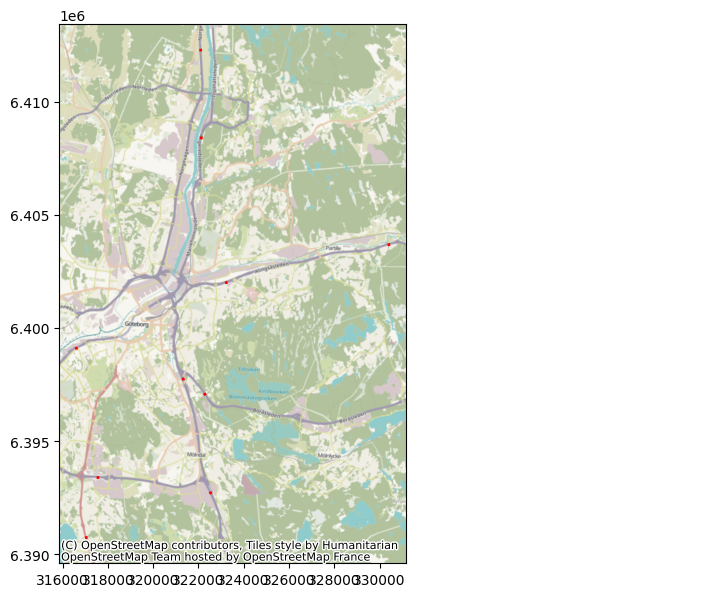

In [15]:
road_sections_gdf = gpd.GeoDataFrame(geometry=road_cong_lines + road_free_lines, crs='EPSG:3006')
#display(road_sections_gdf)

# plot road sections on map
ax = road_sections_gdf.plot(color='red', figsize=(7,7), linewidth=2)
cx.add_basemap(ax, crs=road_sections_gdf.crs.to_string())

In [16]:
# try the same as above but with a spatial join instead
# runtime: 30-40 sec
for idx, section_name in enumerate(road_cong_names):
    # Fetch the buffered polygon around the road section
    road_section = buffered_cong_road_sections[idx]
    # Merge the road section with the trajectories on the traj intersecting
    smerged_gdf = gpd.sjoin(gpd.GeoDataFrame(geometry=[road_section], crs='EPSG:3006'),
                            trajs_gdf, how='right', predicate='intersects')
    # make a column with True if trajectory intersects road section, else False
    trajs_gdf[section_name] = smerged_gdf.index_left.notna()
    print(section_name, 'done.')


angered done.
agnesberg done.
torpamotet done.
kallebäck done.
riksväg_40 done.


In [17]:
# same but for free-flow road sections
# runtime: 30-40 sec
for idx, section_name in enumerate(road_free_names):
    # Fetch the buffered polygon around the road section
    road_section = buffered_free_road_sections[idx]
    # Merge the road section with the trajectories on the traj intersecting
    smerged_gdf = gpd.sjoin(gpd.GeoDataFrame(geometry=[road_section], crs='EPSG:3006'),
                            trajs_gdf, how='right', predicate='intersects')
    # make a column with True if trajectory intersects road section, else False
    trajs_gdf[section_name] = smerged_gdf.index_left.notna()
    print(section_name, 'done.')


järnbrottet done.
askim done.
oscarleden done.
åbymotet done.
jonsered done.


In [18]:
idxs_to_keep = set()
for section_name in (road_cong_names + road_free_names):
    section_idxs = trajs_gdf[trajs_gdf[section_name]].index
    idxs_to_keep.update(section_idxs)

trajs_gdf_filtered = trajs_gdf.loc[list(idxs_to_keep)].sort_index()
trajs_gdf_filtered.shape   

(27584, 17)

In [19]:
# define the acceptable enter and exit angles for each road section
cong_road_headings = {}
for idx, section_name in enumerate(road_cong_names):
    section_heading = get_headings(road_cong_lines[idx])
    cong_road_headings[section_name] = [((section_heading-10)%360, (section_heading+10)%360), ((section_heading-190)%360, (section_heading+190)%360)]

free_road_headings = {}
for idx, section_name in enumerate(road_free_names):
    section_heading = get_headings(road_free_lines[idx])
    free_road_headings[section_name] = [((section_heading-10)%360, (section_heading+10)%360), ((section_heading-190)%360, (section_heading+190)%360)]
free_road_headings

all_road_headings = cong_road_headings | free_road_headings
all_road_headings

{'angered': [(165.6141037975222, 185.6141037975222),
  (345.6141037975222, 5.614103797522205)],
 'agnesberg': [(184.8680947549361, 204.8680947549361),
  (4.868094754936095, 24.868094754936124)],
 'torpamotet': [(242.61013190262807, 262.61013190262804),
  (62.61013190262807, 82.61013190262804)],
 'kallebäck': [(148.86389331191623, 168.86389331191623),
  (328.86389331191623, 348.86389331191623)],
 'riksväg_40': [(137.66448021270747, 157.66448021270747),
  (317.6644802127075, 337.6644802127075)],
 'järnbrottet': [(262.8845632974072, 282.8845632974072),
  (82.88456329740723, 102.88456329740723)],
 'askim': [(154.3178730594462, 174.3178730594462),
  (334.31787305944624, 354.31787305944624)],
 'oscarleden': [(239.99669204884617, 259.99669204884617),
  (59.99669204884617, 79.99669204884617)],
 'åbymotet': [(144.64096843829407, 164.64096843829407),
  (324.64096843829407, 344.64096843829407)],
 'jonsered': [(245.48308841213213, 265.48308841213213),
  (65.48308841213213, 85.48308841213213)]}

In [20]:


cong_dist_points = {section_name: [[get_point(road_cong_lines[idx], 0),
                                     get_point(road_cong_lines[idx], 1)],
                                    cong_road_headings[section_name]] \
                                        for idx, section_name in enumerate(road_cong_names)}

free_dist_points = {section_name: [[get_point(road_free_lines[idx], 0),
                                    get_point(road_free_lines[idx], 1)],
                                    free_road_headings[section_name]] \
                                        for idx, section_name in enumerate(road_free_names)}

# initialize clipping gdf
columns=[name + '_clipped' for name in (road_cong_names+road_free_names)]
clipped_trajectories = pd.DataFrame(index=trajs_gdf_filtered.index, columns=columns)
for idx, section_name in enumerate(road_cong_names+road_free_names):
    mask = trajs_gdf_filtered[section_name] == 1
    trajectory_buffer = (buffered_cong_road_sections+buffered_free_road_sections)[idx] 
    
    
    clipped_trajectories[section_name + '_clipped'] = gpd.clip(trajs_gdf_filtered.line, trajectory_buffer)
    print(section_name, 'clipped')

display(clipped_trajectories.sample(5))



angered clipped
agnesberg clipped
torpamotet clipped
kallebäck clipped
riksväg_40 clipped
järnbrottet clipped
askim clipped
oscarleden clipped
åbymotet clipped
jonsered clipped


,angered_clipped,agnesberg_clipped,torpamotet_clipped,kallebäck_clipped,riksväg_40_clipped,järnbrottet_clipped,askim_clipped,oscarleden_clipped,åbymotet_clipped,jonsered_clipped
sid,,,,,,,,,,
1436939,None,None,None,None,None,"LINESTRING (317485.527 6393391.998, 317496.271...",None,"LINESTRING (316679.856 6399139.979, 316598.723...",None,None
1822431,None,"LINESTRING (322114.193 6408318.238, 322134.499...",None,"LINESTRING (321364.612 6397680.354, 321342.702...",None,None,None,None,None,None
9151764,"LINESTRING (322096.437 6412352.963, 322099.761...",None,None,None,None,None,None,None,None,None
6753135,None,"LINESTRING (322145.280 6408471.781, 322113.246...",None,None,None,None,None,None,None,None
9317270,None,None,None,"LINESTRING (321318.289 6397820.111, 321317.671...",None,None,None,None,None,None


In [21]:
# extract the first trajectory in the MultiLineStrings
for col in clipped_trajectories.columns:
        #is_multi_mask = clipped_trajectories[col].map(lambda x: isinstance(x, MultiLineString))
        clipped_trajectories[col] = clipped_trajectories[col].\
                map(lambda x: get_parts(x)[0] if isinstance(x, MultiLineString) else x)

### HEading GDF

In [22]:
columns = [name + '_heading' for name in (road_cong_names+road_free_names)]

heading_gdf = pd.DataFrame(index = clipped_trajectories.index, columns=columns)
heading_gdf

for col in heading_gdf.columns:
    heading_gdf[col] = clipped_trajectories[col[:-7] + 'clipped'].apply(lambda x: get_headings(x) if x != None else x)

heading_gdf[heading_gdf.angered_heading.notna()]

,angered_heading,agnesberg_heading,torpamotet_heading,kallebäck_heading,riksväg_40_heading,järnbrottet_heading,askim_heading,oscarleden_heading,åbymotet_heading,jonsered_heading
sid,,,,,,,,,,
13,176.742005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,174.739983,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,356.664520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,176.315363,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2152,355.840590,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
9864716,176.227585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9864726,176.279954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9864754,175.939520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
# Starting with an empty mask (all False values)
mask = pd.Series([False] * len(heading_gdf), index=heading_gdf.index)

for road_name in road_cong_names+road_free_names:  # Iterate over road names
    heading_thresholds = all_road_headings[road_name]
    road_column = road_name+'_heading'
    road_mask = (heading_gdf[road_column].notna())  # Start with a mask for the current road
    #print(road_name+'\n', road_mask)
    # Construct heading-based conditions for the current road
    conditions = [
        ((heading_gdf[road_column] >= threshold[0]) & (heading_gdf[road_column] <= threshold[1]))
        for threshold in heading_thresholds
    ]

    # Combine conditions with OR (|)
    combined_conditions = conditions[0]
    for condition in conditions[1:]:
        combined_conditions |= condition

    # Combine road mask with heading-based conditions using AND (&)
    road_mask &= combined_conditions
    #print('road_mask &= combined_conditions---\n', road_mask)

    # Combine with overall mask using OR (|)
    mask |= road_mask
#print('MASK:\n',mask)
#display(heading_gdf.reset_index()[mask])
# Filter the dataframe using the mask
filtered_heading_gdf = heading_gdf[mask].copy()

In [24]:
filtered_heading_gdf.head()

,angered_heading,agnesberg_heading,torpamotet_heading,kallebäck_heading,riksväg_40_heading,järnbrottet_heading,askim_heading,oscarleden_heading,åbymotet_heading,jonsered_heading
sid,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.062062,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.626553
11,NaN,NaN,NaN,158.707720,NaN,NaN,NaN,NaN,154.582931,NaN
13,176.742005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,338.647652,NaN,NaN,NaN,NaN,334.779404,NaN


In [25]:
under_120.head()

,mean_velocity,Number of data points,duration,total_distance,duration/frequency,frequency/duration
old_traj_sid,,,,,,
1,95.627061,56,275.0,7304.844915,4.910714,0.203636
3,95.396003,35,170.0,4504.811231,4.857143,0.205882
4,82.651597,139,710.0,16329.491799,5.107914,0.195775
7,87.946525,83,420.0,10044.958281,5.060241,0.197619
11,88.442302,126,708.0,17367.557538,5.619048,0.177966


In [32]:
# filtered_heading_gdf['speed'] = under_120.loc[under_120.index, 'mean_velocity']
filtered_heading_gdf['speed'] = trajs_gdf.loc[filtered_heading_gdf.index, 'speed']
filtered_heading_gdf['start'] = trajs_gdf.loc[filtered_heading_gdf.index, 'start_time']
filtered_heading_gdf['end'] = trajs_gdf.loc[filtered_heading_gdf.index, 'stop_time']
filtered_heading_gdf["ratio"] = under_120.loc[under_120.index, "frequency/duration"]
filtered_heading_gdf.end = filtered_heading_gdf.end.map(lambda x: x.hour)
filtered_heading_gdf.start = filtered_heading_gdf.start.map(lambda x: x.hour)
filtered_heading_gdf

,angered_heading,agnesberg_heading,torpamotet_heading,kallebäck_heading,riksväg_40_heading,järnbrottet_heading,askim_heading,oscarleden_heading,åbymotet_heading,jonsered_heading,speed,start,end,ratio
sid,,,,,,,,,,,,,,
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.062062,NaN,94.909537,4,5,0.195775
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75.626553,82.495549,9,10,0.197619
11,NaN,NaN,NaN,158.707720,NaN,NaN,NaN,NaN,154.582931,NaN,93.235459,18,18,0.177966
13,176.742005,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,86.270843,11,13,0.188475
14,NaN,NaN,NaN,338.647652,NaN,NaN,NaN,NaN,334.779404,NaN,75.495563,9,10,0.201130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9864756,356.460619,NaN,NaN,NaN,326.748674,NaN,NaN,NaN,NaN,NaN,106.983615,17,18,0.193620
9864758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154.515285,NaN,99.545104,10,11,0.201527
9864760,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.754408,NaN,128.913070,11,12,0.202778


Congested

In [37]:
# tv_angered = {"location": ["angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered", "angered"],
#            "hour": ["2015-11-19 23:00", "2015-11-19 00:00", "2015-11-19 01:00", "2015-11-19 02:00", "2015-11-19 03:00", "2015-11-19 04:00", "2015-11-19 05:00", "2015-11-19 06:00", "2015-11-19 07:00", "2015-11-19 08:00", "2015-11-19 09:00", "2015-11-19 10:00", "2015-11-19 11:00", "2015-11-19 12:00", "2015-11-19 13:00", "2015-11-19 14:00", "2015-11-19 15:00", "2015-11-19 16:00", "2015-11-19 17:00", "2015-11-19 18:00", "2015-11-19 19:00", "2015-11-19 20:00", "2015-11-19 21:00", "2015-11-19 22:00"],
#            "mean_speed": [70.6, 74.2, 75.4, 73.2, 69.7, 73.8, 80, 88.2, 89.2, 90.5, 90.6, 87.9, 87.5, 88.2, 88.7, 86.4, 68.7, 60, 80.2, 88.5, 82.3, 75.4, 74.1, 71.1],
#            "num_cars": [323, 270, 124, 93, 112, 126, 321, 880, 1430, 1265, 1093, 1177, 1424, 1770, 2049, 2412, 2996, 2893, 2265, 1570, 1152, 704, 543, 542]}


# tv_agnesberg = {"location": ["agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg", "agnesberg"],
#            "hour": ["2018-01-09 01:00", "2018-01-09 02:00", "2018-01-09 03:00", "2018-01-09 04:00", "2018-01-09 05:00", "2018-01-09 06:00", "2018-01-09 07:00", "2018-01-09 08:00", "2018-01-09 09:00", "2018-01-09 10:00", "2018-01-09 11:00", "2018-01-09 12:00", "2018-01-09 13:00", "2018-01-09 14:00", "2018-01-09 15:00", "2018-01-09 16:00", "2018-01-09 17:00", "2018-01-09 18:00", "2018-01-09 19:00", "2018-01-09 20:00", "2018-01-09 21:00", "2018-01-09 22:00", "2018-01-09 23:00", "2018-01-09 00:00", ],
#            "mean_speed": [93.3, 93.9, 93.3, 96.7, 94, 94.7, 91.3, 92.4, 91.4, 92.3, 91.9, 94.7, 93.9, 92, 91.1, 61.4, 89.1, 91.1, 91.4, 93.7, 92.6, 92.4, 92.7, 96.6],
#            "num_cars": [70, 49, 43, 73, 207, 770, 1138, 998, 658, 690, 694, 809, 853, 1141, 1805, 2164, 1397, 898, 692, 509, 479, 342, 213, 123]}

# tv_torpamotet = {"location": ["torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", "torpamotet", ],
#            "hour": ["2019-10-07 22:00",  "2019-10-07 23:00", "2019-10-07 00:00", "2019-10-07 01:00", "2019-10-07 02:00", "2019-10-07 03:00", "2019-10-07 04:00", "2019-10-07 05:00", "2019-10-07 06:00", "2019-10-07 07:00", "2019-10-07 08:00", "2019-10-07 09:00", "2019-10-07 10:00", "2019-10-07 11:00", "2019-10-07 12:00", "2019-10-07 13:00", "2019-10-07 14:00", "2019-10-07 15:00", "2019-10-07 16:00", "2019-10-07 17:00", "2019-10-07 18:00", "2019-10-07 19:00", "2019-10-07 20:00", "2019-10-07 21:00"],
#            "mean_speed": [75.8, 77.6, 74.9, 79.8, 74.2, 79.2, 80.6, 76.3, 71.3, 61.2, 58.4, 69.6, 70.4, 68.6, 70.2, 72.2, 69.6, 69.2, 69, 70, 70.4, 71.9, 71.9, 73.6],
#            "num_cars": [137, 61, 41, 25, 20, 14, 30, 170, 532, 746, 515, 418, 387, 446, 432, 384, 457, 657, 664, 461, 380, 312, 260, 273]}

# tv_kalleback = {"location": ["kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", "kallebäck", ],
#            "hour": ["2019-04-04 02:00", "2019-04-04 03:00", "2019-04-04 04:00", "2019-04-04 05:00", "2019-04-04 06:00", "2019-04-04 07:00", "2019-04-04 08:00", "2019-04-04 09:00", "2019-04-04 10:00", "2019-04-04 11:00", "2019-04-04 12:00", "2019-04-04 13:00", "2019-04-04 14:00", "2019-04-04 15:00", "2019-04-04 16:00", "2019-04-04 17:00", "2019-04-04 18:00", "2019-04-04 19:00", "2019-04-04 20:00", "2019-04-04 21:00", "2019-04-04 22:00", "2019-04-04 23:00", "2019-04-04 00:00", "2019-04-04 01:00"],
#            "mean_speed": [87.4, 91.4, 89.7, 89.6, 88, 71.9, 34.3, 84.5, 85.1, 85.2, 85.7, 85.6, 84.8, 42.6, 31.3, 56.2, 86.4, 89.4, 87.6, 87.9, 89.6, 90.6, 78.6, 81.4],
#            "num_cars": [74, 93, 165, 164, 2381, 2710, 2336, 2003, 1870, 2047, 2100, 2179, 2446, 2357, 2014, 2348, 1942, 1357, 1054, 905, 648, 312, 234, 114]}

# tv_riksvag_40 = {"location": ["riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40", "riksväg_40"],
#            "hour": ["2018-09-27 22:00", "2018-09-27 23:00", "2018-09-27 00:00", "2018-09-27 01:00", "2018-09-27 02:00", "2018-09-27 03:00", "2018-09-27 04:00", "2018-09-27 05:00", "2018-09-27 06:00", "2018-09-27 07:00", "2018-09-27 08:00", "2018-09-27 09:00", "2018-09-27 10:00", "2018-09-27 11:00", "2018-09-27 12:00", "2018-09-27 13:00", "2018-09-27 14:00", "2018-09-27 15:00", "2018-09-27 16:00", "2018-09-27 17:00", "2018-09-27 18:00", "2018-09-27 19:00", "2018-09-27 20:00", "2018-09-27 21:00"],
#            "mean_speed": [92.9, 95.4, 90.2, 87.5, 88, 88.1, 91.9, 90.3, 90.2, 88.7, 89.6, 90.2, 90, 89.7, 91, 91.1, 91.3, 91.2, 91.2, 82.6, 90.2, 88.9, 89.8, 89.9],
#            "num_cars": [756, 356, 205, 128, 97, 158, 535, 989, 1687, 2352, 2177, 1794, 1737, 1785, 1931, 2389, 2514, 2826, 2943, 2510, 1785, 1366, 957, 782]}

# df_angered = pd.DataFrame(tv_angered)
# df_agnesberg = pd.DataFrame(tv_agnesberg)
# df_torpamotet = pd.DataFrame(tv_torpamotet)
# df_kalleback = pd.DataFrame(tv_kalleback)
# df_riksvag_40 = pd.DataFrame(tv_riksvag_40)

# tv_df = pd.concat([df_angered, df_agnesberg, df_torpamotet, df_kalleback, df_riksvag_40], axis=0).reset_index(drop=True)

# tv_df["hour"] = pd.to_datetime(tv_df["hour"])

Freeflow

In [27]:
tv_jarnbrottet = {"location": ["järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", "järnbrottet", ],
           "hour": ["2018-12-18 23:00", "2018-12-18 00:00", "2018-12-18 01:00", "2018-12-18 02:00", "2018-12-18 03:00", "2018-12-18 04:00", "2018-12-18 05:00", "2018-12-18 06:00", "2018-12-18 07:00", "2018-12-18 08:00", "2018-12-18 09:00", "2018-12-18 10:00", "2018-12-18 11:00", "2018-12-18 12:00", "2018-12-18 13:00", "2018-12-18 14:00", "2018-12-18 15:00", "2018-12-18 16:00", "2018-12-18 17:00", "2018-12-18 18:00", "2018-12-18 19:00", "2018-12-18 20:00", "2018-12-18 21:00", "2018-12-18 22:00", ],
           "mean_speed": [86.7, 85.6, 88.2, 88.9, 83.4, 85, 86.1, 82.9, 74.2, 76, 80.6, 79.1, 79.1, 77.7, 78.4, 77.9, 75.7, 74.6, 76.1, 79.5, 81.7, 82.6, 83.6, 82.9],
           "num_cars": [176, 212, 93, 55, 73, 135, 591, 2058, 3351, 2977, 1988, 2164, 2333, 2484, 2394, 2687, 3235, 3084, 2563, 1866, 1356, 945, 652, 345]}

#
tv_askim = {"location": ["askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", "askim", ],
           "hour": ["2017-08-23 12:00", "2017-08-23 13:00", "2017-08-23 14:00", "2017-08-23 15:00", "2017-08-23 16:00", "2017-08-23 17:00", "2017-08-23 18:00", "2017-08-23 19:00", "2017-08-23 20:00", "2017-08-23 21:00", "2017-08-23 22:00", "2017-08-23 23:00", "2017-08-23 00:00", "2017-08-23 01:00", "2017-08-23 02:00", "2017-08-23 03:00", "2017-08-23 04:00", "2017-08-23 05:00", "2017-08-23 06:00", "2017-08-23 07:00", "2017-08-23 08:00", "2017-08-23 09:00", "2017-08-23 10:00", "2017-08-23 11:00", ],
           "mean_speed": [77.3, 76.4, 74, 75.8, 76.7, 75.2, 76.1, 75.8, 75.3, 77, 79.2, 82, 80.2, 85.8, 82.4, 88.2, 91.2, 86.7, 82.4, 69.4, 66.9, 75.1, 75.6, 74.3],
           "num_cars": [818, 850, 989, 1114, 1142, 999, 824, 720, 713, 461, 208, 73, 40, 26, 18, 9, 42, 288, 1230, 2510, 2879, 958, 838, 891]}

tv_oscarleden = {"location": ["oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", "oscarleden", ],
           "hour": ["2019-12-05 12:00", "2019-12-05 13:00", "2019-12-05 14:00", "2019-12-05 15:00", "2019-12-05 16:00", "2019-12-05 17:00", "2019-12-05 18:00", "2019-12-05 19:00", "2019-12-05 20:00", "2019-12-05 21:00", "2019-12-05 22:00", "2019-12-05 23:00", "2019-12-05 00:00", "2019-12-05 01:00", "2019-12-05 02:00", "2019-12-05 03:00", "2019-12-05 04:00", "2019-12-05 05:00", "2019-12-05 06:00", "2019-12-05 07:00", "2019-12-05 08:00", "2019-12-05 09:00", "2019-12-05 10:00", "2019-12-05 11:00", ],
           "mean_speed": [76.7, 75.4, 75.7, 73.6, 73, 72.6, 76, 77.5, 77.5, 77.5, 78.2, 81.5, 78.9, 81.6, 79.8, 77.8, 82.2, 80.3, 80.6, 74.7, 75, 74.2, 76.6, 75.6],
           "num_cars": [1244, 1411, 1622, 2310, 2082, 1925, 1246, 803, 673, 589, 441, 254, 235, 111, 82, 52, 99, 387, 1134, 2019, 1930, 1300, 1236, 1455]}

tv_abymotet = {"location": ["åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", "åbymotet", ],
               "hour": ["2019-10-10 12:00", "2019-10-10 13:00", "2019-10-10 14:00", "2019-10-10 15:00", "2019-10-10 16:00", "2019-10-10 17:00", "2019-10-10 18:00", "2019-10-10 19:00", "2019-10-10 20:00", "2019-10-10 21:00", "2019-10-10 22:00", "2019-10-10 23:00", "2019-10-10 00:00", "2019-10-10 01:00", "2019-10-10 02:00", "2019-10-10 03:00", "2019-10-10 04:00", "2019-10-10 05:00", "2019-10-10 06:00", "2019-10-10 07:00", "2019-10-10 08:00", "2019-10-10 09:00", "2019-10-10 10:00", "2019-10-10 11:00"],
               "mean_speed": [74.7, 74.4, 75.1, 76.3, 76.9, 76.2, 75.5, 73.1, 73.8, 74.6, 75.1, 78.4, 75.4, 73.6, 69.6, 73.6, 77.4, 77.5, 72.6, 71.1, 74.2, 75.2, 74.8, 74.8],
               "num_cars": [784, 828, 936, 981, 1127, 930, 758, 551, 382, 239, 153, 122, 59, 33, 15, 34, 76, 518, 1749, 2147, 1471, 833, 820, 857]}

tv_jonsered = {"location": ["jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered", "jonsered"],
               "hour": ["2018-07-04 22:00", "2018-07-04 23:00", "2018-07-04 00:00", "2018-07-04 01:00", "2018-07-04 02:00", "2018-07-04 03:00", "2018-07-04 04:00", "2018-07-04 05:00", "2018-07-04 06:00", "2018-07-04 07:00", "2018-07-04 08:00", "2018-07-04 09:00", "2018-07-04 10:00", "2018-07-04 11:00", "2018-07-04 12:00", "2018-07-04 13:00", "2018-07-04 14:00", "2018-07-04 15:00", "2018-07-04 16:00", "2018-07-04 17:00", "2018-07-04 18:00", "2018-07-04 19:00", "2018-07-04 20:00", "2018-07-04 21:00", ],
               "mean_speed": [95.2, 95.5, 96.1, 92.6, 94, 93.3, 97.2, 100.7, 99.7, 96.5, 96.3, 93.3, 91.0, 92.4, 92.8, 92.6, 93.4, 93.4, 93.4, 94, 94.6, 97.2, 95, 97.2],
               "num_cars": [378, 213, 100, 80, 66, 63, 111, 748, 2230, 2237, 1566, 1146, 1286, 1312, 1134, 1091, 1253, 1354, 1402, 1239, 1057, 710, 637, 542]}

df_jarnbrottet = pd.DataFrame(tv_jarnbrottet)
df_askim = pd.DataFrame(tv_askim)
df_oscarleden = pd.DataFrame(tv_oscarleden)
df_abymotet = pd.DataFrame(tv_abymotet)
df_jonsered = pd.DataFrame(tv_jonsered)

tv_df = pd.concat([df_jarnbrottet, df_askim, df_oscarleden, df_abymotet, df_jonsered], axis=0).reset_index(drop=True)

tv_df["hour"] = pd.to_datetime(tv_df["hour"])


In [33]:
### Keep only freeflow roads

cong_to_drop = ['angered_heading', 'agnesberg_heading', 'torpamotet_heading', 'kallebäck_heading', 'riksväg_40_heading']
free_filtered_heading_gdf = filtered_heading_gdf.copy()
free_filtered_heading_gdf = free_filtered_heading_gdf[pd.isna(free_filtered_heading_gdf[cong_to_drop]).all(axis=1)]

### Keep only congested roads

free_to_drop = ['järnbrottet_heading', 'askim_heading', 'oscarleden_heading', 'åbymotet_heading', 'jonsered_heading']
cong_filtered_heading_gdf = filtered_heading_gdf.copy()
cong_filtered_heading_gdf = cong_filtered_heading_gdf[pd.isna(cong_filtered_heading_gdf[free_to_drop]).all(axis=1)]

In [34]:
### Freeflow
free_filtered_heading_gdf = free_filtered_heading_gdf.drop(columns=cong_to_drop)
free_filtered_heading_gdf.head()

### Congested
cong_filtered_heading_gdf = cong_filtered_heading_gdf.drop(columns=free_to_drop)
cong_filtered_heading_gdf.head()

,angered_heading,agnesberg_heading,torpamotet_heading,kallebäck_heading,riksväg_40_heading,speed,start,end,ratio
sid,,,,,,,,,
13,176.742005,NaN,NaN,NaN,NaN,86.270843,11,13,0.188475
15,NaN,195.278643,NaN,NaN,NaN,93.052112,6,6,0.201942
33,174.739983,NaN,NaN,NaN,NaN,91.748067,12,13,0.201149
37,NaN,193.790488,NaN,NaN,NaN,87.743662,6,7,0.201515
47,NaN,NaN,NaN,NaN,326.213979,88.950934,12,13,0.201156


In [35]:
### Congested
sorted_cong_filtered_gdf = cong_filtered_heading_gdf.sort_values("ratio")

### Freeflow
sorted_free_filtered_gdf = free_filtered_heading_gdf.sort_values("ratio")

In [36]:
### Congested
sorted_cong_filtered_gdf = sorted_cong_filtered_gdf.loc[~sorted_cong_filtered_gdf["ratio"].isna()]
sorted_cong_filtered_gdf = sorted_cong_filtered_gdf.loc[sorted_cong_filtered_gdf["ratio"] > 0]

# median_value = sorted_cong_filtered_gdf["ratio"].median()

# lower_half = sorted_cong_filtered_gdf.loc[sorted_cong_filtered_gdf["ratio"] < median_value]
# upper_half = sorted_cong_filtered_gdf.loc[sorted_cong_filtered_gdf["ratio"] >= median_value]

### Freeflow

sorted_free_filtered_gdf = sorted_free_filtered_gdf.loc[~sorted_free_filtered_gdf["ratio"].isna()]
sorted_free_filtered_gdf = sorted_free_filtered_gdf.loc[sorted_free_filtered_gdf["ratio"] > 0]

median_value = sorted_free_filtered_gdf["ratio"].median()

lower_half = sorted_free_filtered_gdf.loc[sorted_free_filtered_gdf["ratio"] < median_value]
upper_half = sorted_free_filtered_gdf.loc[sorted_free_filtered_gdf["ratio"] >= median_value]

In [37]:
len(sorted_free_filtered_gdf)

7877

In [38]:
len(sorted_cong_filtered_gdf)

10336

In [63]:
lower_hourly_avg_speed = lower_half.groupby('start')['speed'].mean().reset_index()
upper_hourly_avg_speed = upper_half.groupby('start')['speed'].mean().reset_index()


In [40]:
# road_df = free_filtered_heading_gdf.loc[:, free_filtered_heading_gdf.columns[5:10]]
# # road_df = filtered_heading_gdf.loc[:, filtered_heading_gdf.columns[:5]]
# # road_df = pd.concat([road_df, filtered_heading_gdf.loc[:, filtered_heading_gdf.columns[-3:]]], axis=1)
# hourly_avg_speed = road_df.groupby('start')['speed'].mean()
# hourly_counts = road_df.groupby('start').size()

### Above is not needed ###

### Freeflow
# hourly_avg_speed = free_filtered_heading_gdf.groupby("start")["speed"].mean()
# hourly_counts = free_filtered_heading_gdf.groupby("start").size()

### Congested
# hourly_avg_speed = cong_filtered_heading_gdf.groupby("start")["speed"].mean()
# hourly_counts = cong_filtered_heading_gdf.groupby("start").size()

In [64]:
tv_df['plot_hour'] = tv_df['hour'].map(lambda x: x.hour)

tv_hourly_avg_speed = tv_df.groupby('plot_hour')['mean_speed'].mean().reset_index()
tv_hourly_total_cars = tv_df.groupby('plot_hour')['num_cars'].sum().reset_index()

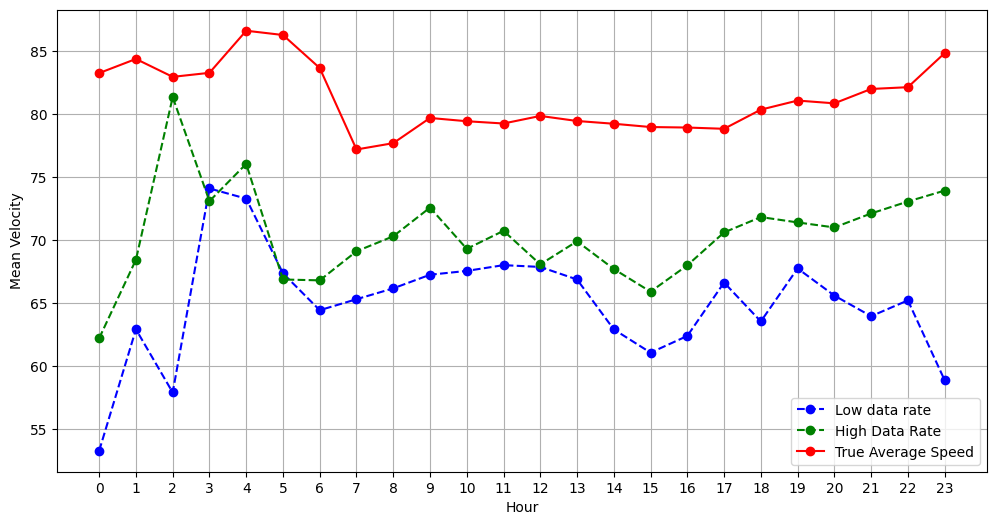

In [65]:
# Plot mean velocity for lower_half
plt.figure(figsize=(12, 6))
plt.plot(lower_hourly_avg_speed['start'], lower_hourly_avg_speed['speed'], marker='o', linestyle='--', color='blue', label='Low data rate')
plt.xlabel('Hour')
plt.ylabel('Mean Velocity km/h')
# plt.title('Mean Velocity for Lower Half')
plt.grid(True)

# Plot mean velocity for upper_half
plt.plot(upper_hourly_avg_speed['start'], upper_hourly_avg_speed['speed'], marker='o', linestyle='--', color='green', label='High Data Rate')

# Plot mean speed for tv_hourly_avg_speed
plt.plot(tv_hourly_avg_speed['plot_hour'], tv_hourly_avg_speed['mean_speed'], marker='o', linestyle='-', color='red', label='True Average Speed')

plt.xlabel('Hour')
plt.ylabel('Mean Velocity')
plt.legend()
plt.xticks(upper_hourly_avg_speed['start'])  # Set x-axis ticks explicitly

plt.grid(True)
plt.savefig("Ratio_combined_free_new.png")

plt.show()

In [66]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Calculate MSE and RMSE for lower_half compared to TV
mse_lower = mean_squared_error(tv_hourly_avg_speed['mean_speed'], lower_hourly_avg_speed['speed'])
rmse_lower = np.sqrt(mse_lower)

# Calculate MSE and RMSE for upper_half compared to TV
mse_upper = mean_squared_error(tv_hourly_avg_speed['mean_speed'], upper_hourly_avg_speed['speed'])
rmse_upper = np.sqrt(mse_upper)

print(f'MSE for Lower Half compared to TV: {mse_lower}')
print(f'RMSE for Lower Half compared to TV: {rmse_lower}\n')

print(f'MSE for Upper Half compared to TV: {mse_upper}')
print(f'RMSE for Upper Half compared to TV: {rmse_upper}')


MSE for Lower Half compared to TV: 289.75148377600993
RMSE for Lower Half compared to TV: 17.022088114447357

MSE for Upper Half compared to TV: 133.36901590954778
RMSE for Upper Half compared to TV: 11.548550381305343


c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
c:\Users\Timze\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a